---
# 👶🏻🍼 Classificazione automatica del pianto neonatale mediante reti neurali: Transfer learning con PANNs (CNN pre-addestrata) + Transformer Classifier + Kfold validation
---
By: Beatrice & Giorgia 👩🏻 👩🏻‍🦰


---

1.   **SET UP:**
installazioni, importo librerie


2.   **VISIONE GLOBALE DEL DATASET:** frequenza classi, statistiche durata audio


3. **DATA AUGMENTATION:** split dataset (85%-15%), data augmentation offline

4. **TRANSFER LEARNING:** estraggo e salvo embeddings audio usando il modello pre-addestrato PANNs

5. **TRAIN:** transformer encoder, k-fold cross validation, loss pesate, ottimizzatore Adam con scheduler, early stopping

6. **RISULTATI OTTENUTI:** andamento della loss e dell'errore di ogni fold, matrice di confusione (multiclasse e binaria)




##⚙️ SET UP

In [1]:
!pip install audiomentations
!pip install torchlibrosa git+https://github.com/qiuqiangkong/panns_inference.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: soxr
    Found existing installation: soxr 1.0.0
    Uninstalling soxr-1.0.0:
      Successfully uninstalled soxr-1.0.0
  Cloning https://github.com/qiuqiangkong/panns_inference.git to /tmp/pip-req-build-vfjwh4xe
  Running command git clone --filter=blob:none --quiet https://github.com/qiuqiangkong/panns_inference.git /tmp/pip-req-build-vfjwh4xe
  Resolved https://github.com/qiuqiangkong/panns_inference.git to commit f673f604ec6f4805a61c5b3be087e24776ec5fda
  Preparing metadata (setup.py) ... done
  Created wheel for panns-inference: filename=panns_inference-0.1.1-py3-none-any.whl size=8266 sha256=5bd7df1d8082d4737f965a541a5ad334c8d0d1c73193ec5b1ed16af5043e091c
  Stored in directory: /tmp/pip-ephem-wheel-cache-tdf9likk/wheels/5

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import plotly.express as px
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import librosa.display
import soundfile as sf
import random
import shutil
import hashlib

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from collections import defaultdict
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, classification_report
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, ClippingDistortion, PolarityInversion
from torchvision import models
from sklearn.manifold import TSNE
from panns_inference import AudioTagging
from tqdm import tqdm

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
#torch.cuda.manual_seed(42)
#torch.backends.cudnn.deterministic = True

In [4]:
# Cloniamo l'intero repository
!git clone https://github.com/gveres/donateacry-corpus.git

Cloning into 'donateacry-corpus'...
remote: Enumerating objects: 1616, done.
remote: Total 1616 (delta 0), reused 0 (delta 0), pack-reused 1616 (from 1)
Receiving objects: 100% (1616/1616), 67.06 MiB | 34.00 MiB/s, done.
Resolving deltas: 100% (43/43), done.


## 🗂️ VISIONE GLOBALE DEL DATASET


Numero file per dataset:
dataset
donateacry-android-upload-bucket              712
donateacry-ios-upload-bucket                  416
donateacry_corpus_cleaned_and_updated_data    457
Name: file, dtype: int64

Numero file per classe in ciascun dataset:
dataset                                     label                           
donateacry-android-upload-bucket            donateacry-android-upload-bucket    712
donateacry-ios-upload-bucket                donateacry-ios-upload-bucket        416
donateacry_corpus_cleaned_and_updated_data  belly_pain                           16
                                            burping                               8
                                            discomfort                           27
                                            hungry                              382
                                            tired                                24
Name: file, dtype: int64

Statistiche sulla durata (secondi):
                    

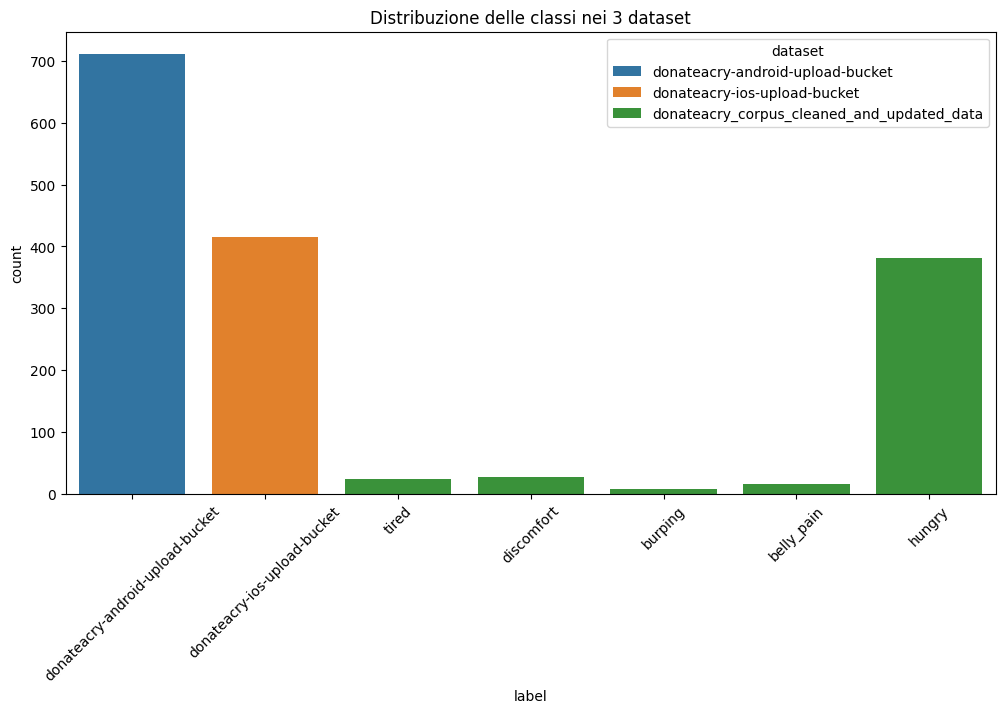

In [5]:
# Percorso principale del dataset
base_path = "donateacry-corpus"

folders = [
    "donateacry-android-upload-bucket",
    "donateacry-ios-upload-bucket",
    "donateacry_corpus_cleaned_and_updated_data"
]

results = []

# Loop su tutte le cartelle
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for root, dirs, files in os.walk(folder_path):
        label = os.path.basename(root)
        for file in files:
            if file.endswith((".wav", ".caf", ".3gp")):
                filepath = os.path.join(root, file)
                try:
                    y, sr = librosa.load(filepath, sr=None)
                    duration = librosa.get_duration(y=y, sr=sr)
                    results.append([folder, label, file, sr, duration])
                except Exception as e:
                    print(f"Errore su {filepath}: {e}")

# DataFrame con i metadati
df = pd.DataFrame(results, columns=["dataset", "label", "file", "sample_rate", "duration"])

# Statistiche numeriche
print("\nNumero file per dataset:")
print(df.groupby("dataset")["file"].count())

print("\nNumero file per classe in ciascun dataset:")
print(df.groupby(["dataset", "label"])["file"].count())

print("\nStatistiche sulla durata (secondi):")
print(df.groupby("dataset")["duration"].describe())

# Grafico: distribuzione classi (istogramma)
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="label", hue="dataset")
plt.title("Distribuzione delle classi nei 3 dataset")
plt.xticks(rotation=45)
plt.show()


##📊 DATA AUGMENTATION

In [6]:
# ============================================================
# Split train/test del dataset originale
# ============================================================

data_path = "donateacry-corpus/donateacry_corpus_cleaned_and_updated_data"

# Lista dei file originali e delle label
original_file_paths = []
original_labels = []

for label in os.listdir(data_path):
    label_folder = os.path.join(data_path, label)
    if os.path.isdir(label_folder):
        for file in os.listdir(label_folder):
            if file.endswith(".wav"):
                original_file_paths.append(os.path.join(label_folder, file))
                original_labels.append(label)

# Split stratificato: 85% train, 15% test
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    original_file_paths, original_labels, test_size=0.15, stratify=original_labels, random_state=42
)

print("Train originale:", len(X_train_orig))
print("Test:", len(X_test))

Train originale: 388
Test: 69


In [14]:
#========================================================================================
# Bilancio il dataset generando versioni augmentate degli audio originali per ogni classe
#========================================================================================

# Cartella di destinazione solo per gli augmentati
augmented_path = "donateacry-corpus/donateacry_augmented_train"

# Pulizia cartella
if os.path.exists(augmented_path):
    shutil.rmtree(augmented_path)
os.makedirs(augmented_path, exist_ok=True)

# Parametri di augmentazione
crop_duration = 3
noise_level = 0.05
volume_factor_range = [0.8, 1.2]
speed_factor_range = [0.8, 1.2]
pitch_semitones_range = [-2, 2]

def augment_audio(y, sr):
    aug_list = []

    # random crop
    if len(y) > crop_duration * sr:
        crop_start = np.random.uniform(0, len(y) - crop_duration * sr)
        y = y[int(crop_start):int(crop_start + crop_duration * sr)]

    # noise
    if random.random() < 0.4:
        y = y + np.random.normal(0, noise_level, len(y))
        aug_list.append("noise")

    # volume
    if random.random() < 0.4:
        vol = np.random.uniform(*volume_factor_range)
        y = y * vol
        aug_list.append(f"vol{vol:.2f}")

    # speed
    if random.random() < 0.3:
        speed = np.random.uniform(*speed_factor_range)
        y = librosa.effects.time_stretch(y=y, rate=speed)
        aug_list.append(f"spd{speed:.2f}")

    # pitch
    if random.random() < 0.3:
        semitones = np.random.uniform(*pitch_semitones_range)
        y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=semitones)
        aug_list.append(f"pch{semitones:.2f}")

    # normalizzazione
    y = y / np.max(np.abs(y) + 1e-6)
    aug_tag = "_".join(aug_list) if aug_list else "orig"
    return y.astype(np.float32), aug_tag

# Raggruppa file di train per classe
train_files_by_label = defaultdict(list)
for file, label in zip(X_train_orig, y_train_orig):
    train_files_by_label[label].append(file)

# Numero target per classe
target_counts = {
    "hungry": 450,
    "belly_pain": 80,
    "discomfort": 80,
    "tired": 80,
    "burping": 80
}

# Genero audio augmentati
for label, files in train_files_by_label.items():
    dst_folder = os.path.join(augmented_path, label)
    os.makedirs(dst_folder, exist_ok=True)
    current_count = len(files)
    num_needed = max(0, target_counts[label] - current_count)
    print(f"{label}: {current_count} originali, generazione {num_needed} augmentati...")

    for i in range(num_needed):
        src_file = random.choice(files)
        y, sr = librosa.load(src_file, sr=22050)
        y_aug, tag = augment_audio(y, sr)
        out_name = f"aug_{i}_{tag}_{os.path.basename(src_file)}"
        sf.write(os.path.join(dst_folder, out_name), y_aug, sr)


hungry: 324 originali, generazione 126 augmentati...
belly_pain: 14 originali, generazione 66 augmentati...
discomfort: 23 originali, generazione 57 augmentati...
burping: 7 originali, generazione 73 augmentati...
tired: 20 originali, generazione 60 augmentati...


Conteggi TRAIN per classe (escludendo test):
hungry       | originali:  324 | augmentati:  126 | totali:  450
belly_pain   | originali:   14 | augmentati:   66 | totali:   80
discomfort   | originali:   23 | augmentati:   57 | totali:   80
burping      | originali:    7 | augmentati:   73 | totali:   80
tired        | originali:   20 | augmentati:   60 | totali:   80


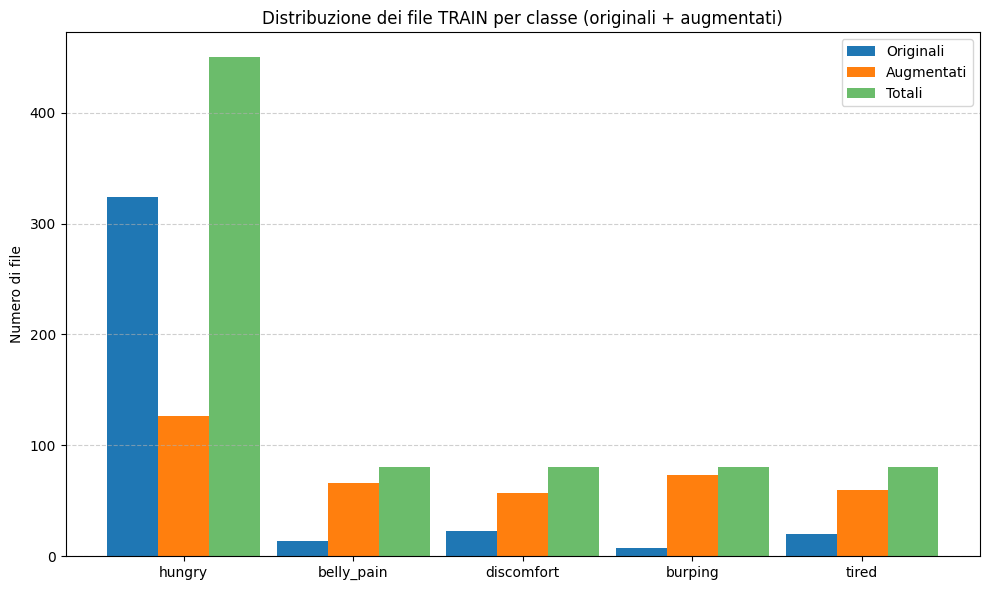

In [15]:
# ======================================================================
# Riepilogo finale: Conteggio file TRAIN per classe (originali + augmentati) -> verifica
# ======================================================================

train_counts = defaultdict(lambda: {"original": 0, "augmentati": 0})

for label, files in train_files_by_label.items():
    # Originali di train
    train_counts[label]["original"] = len(files)

    # Augmentati generati da questi originali
    aug_folder = os.path.join(augmented_path, label)
    if os.path.isdir(aug_folder):
        aug_files = [f for f in os.listdir(aug_folder) if f.endswith(".wav")]
        train_counts[label]["augmentati"] = len(aug_files)

# Stampa riepilogo
print("Conteggi TRAIN per classe (escludendo test):")
for label in train_counts.keys():
    original = train_counts[label]["original"]
    augmentati = train_counts[label]["augmentati"]
    totale = original + augmentati
    print(f"{label:12s} | originali: {original:4d} | augmentati: {augmentati:4d} | totali: {totale:4d}")

# Istogramma file originali + augmentati
labels = list(train_counts.keys())
originali = [train_counts[l]["original"] for l in labels]
augmentati = [train_counts[l]["augmentati"] for l in labels]
totali = [o + a for o, a in zip(originali, augmentati)]

plt.figure(figsize=(10, 6))
x = range(len(labels))
bar_width = 0.3

plt.bar(x, originali, width=bar_width, label="Originali")
plt.bar([i + bar_width for i in x], augmentati, width=bar_width, label="Augmentati")
plt.bar([i + 2*bar_width for i in x], totali, width=bar_width, label="Totali", alpha=0.7)

plt.xticks([i + bar_width for i in x], labels)
plt.ylabel("Numero di file")
plt.title("Distribuzione dei file TRAIN per classe (originali + augmentati)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()




## 👩‍🏫 TRANSFER LEARNING

In [16]:
# ============================================================
# Estrazione degli EMBEDDINGS con PANNs
# ============================================================
# Serve a trasformare gli audio .wav in vettori numerici (embedding) usando un modello pre-addestrato (PANNs) e salvarli su disco, così da non doverli ricalcolare ogni volta


# Impostazione del dispositivo e del modello
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
panns_model = AudioTagging(checkpoint_path=None, device=device)

# Creazione cartella di output
os.makedirs("embeddings", exist_ok=True)

# Definizione della funzione salvataggio embeddings
def save_embeddings(file_paths, labels, split_name):
    embeddings_list = []
    labels_list = []

    for i, (filepath, label) in enumerate(tqdm(zip(file_paths, labels), total=len(file_paths))):
        y, sr = librosa.load(filepath, sr=32000, mono=True)
        with torch.no_grad():
            _, embedding = panns_model.inference(y[None, :])
        embedding = torch.tensor(embedding, dtype=torch.float32).squeeze(0)
        embedding = embedding / (embedding.norm() + 1e-6)
        embeddings_list.append(embedding)
        labels_list.append(label)

    embeddings_tensor = torch.stack(embeddings_list)
    labels_tensor = torch.tensor(labels_list, dtype=torch.long)

    torch.save((embeddings_tensor, labels_tensor), f"embeddings/{split_name}.pt")
    print(f"Saved embeddings for {split_name} ({len(labels_list)} samples).")


# Directory con i file augmentati
data_path_augmented = augmented_path

# Lista dei file augmentati
aug_file_paths = []
aug_labels = []
label2idx = {}  # mapping label->indice
idx = 0

for label in os.listdir(data_path_augmented):
    label_folder = os.path.join(data_path_augmented, label)
    if os.path.isdir(label_folder):
        if label not in label2idx:
            label2idx[label] = idx
            idx += 1
        for file in os.listdir(label_folder):
            if file.endswith(".wav"):
                aug_file_paths.append(os.path.join(label_folder, file))
                aug_labels.append(label2idx[label])

# Carica gli augmentati
X_train_aug = []
y_train_aug = []

for label in os.listdir(augmented_path):
    label_folder = os.path.join(augmented_path, label)
    if os.path.isdir(label_folder):
        for file in os.listdir(label_folder):
            if file.endswith(".wav"):
                X_train_aug.append(os.path.join(label_folder, file))
                y_train_aug.append(label2idx[label])

# Trasformo le label originali in indici
y_train_orig_idx = [label2idx[l] for l in y_train_orig]

# Combino originali + augmentati
X_train = X_train_orig + X_train_aug
y_train = y_train_orig_idx + y_train_aug

print(f"Totale X_train: {len(X_train)} (originali {len(X_train_orig)} + augmentati {len(X_train_aug)})")

# Salvo embeddings di train e test
save_embeddings(X_train, y_train, "train")
save_embeddings(X_test, [label2idx[l] for l in y_test], "test")



Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Totale X_train: 770 (originali 388 + augmentati 382)


100%|██████████| 770/770 [05:43<00:00,  2.24it/s]


Saved embeddings for train (770 samples).


100%|██████████| 69/69 [00:40<00:00,  1.71it/s]

Saved embeddings for test (69 samples).


## 🧠 TRAIN


--- Fold 1/7 ---
Epoch 1: Miglior modello salvato (Train Loss=1.5536)
Epoch 1/50 | Train Loss: 1.5536 | Train Acc: 0.2621 | Train Recall: 0.2513 | Val Loss: 2.8914 | Val Acc: 0.1000 | Val Recall: 0.2202
Epoch 2: Miglior modello salvato (Train Loss=1.3838)
Epoch 2/50 | Train Loss: 1.3838 | Train Acc: 0.3682 | Train Recall: 0.3557 | Val Loss: 2.5463 | Val Acc: 0.1818 | Val Recall: 0.3424
Epoch 3: Miglior modello salvato (Train Loss=1.0689)
Epoch 3/50 | Train Loss: 1.0689 | Train Acc: 0.4939 | Train Recall: 0.4782 | Val Loss: 2.2257 | Val Acc: 0.2000 | Val Recall: 0.3698
Epoch 4: Miglior modello salvato (Train Loss=0.8786)
Epoch 4/50 | Train Loss: 0.8786 | Train Acc: 0.5545 | Train Recall: 0.5465 | Val Loss: 2.4081 | Val Acc: 0.1909 | Val Recall: 0.3338
Epoch 5: Miglior modello salvato (Train Loss=0.8358)
Epoch 5/50 | Train Loss: 0.8358 | Train Acc: 0.5818 | Train Recall: 0.5916 | Val Loss: 2.1379 | Val Acc: 0.2455 | Val Recall: 0.3943
Epoch 6: Miglior modello salvato (Train Loss=0.7725)

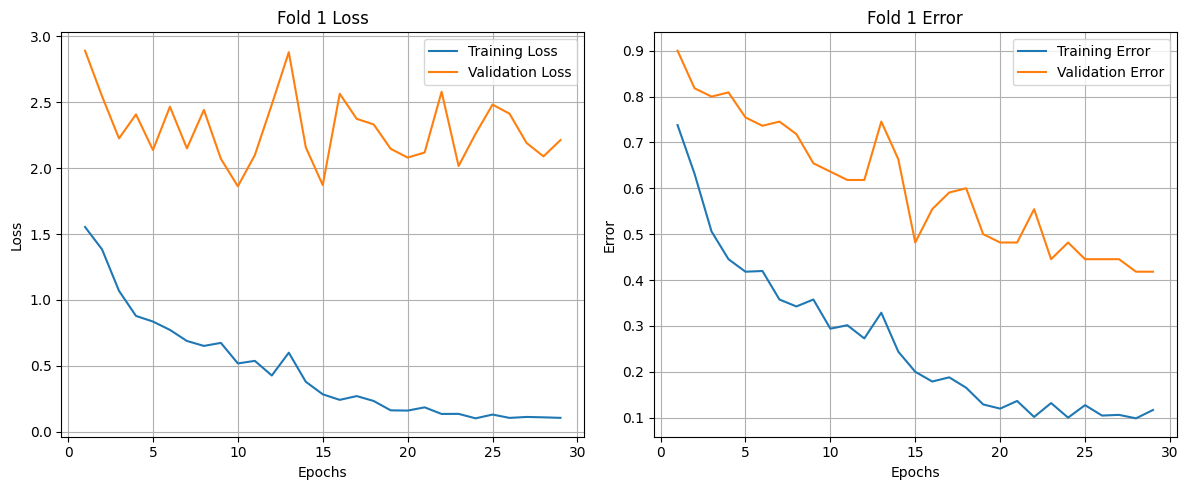


--- Fold 2/7 ---
Epoch 1: Miglior modello salvato (Train Loss=1.5606)
Epoch 1/50 | Train Loss: 1.5606 | Train Acc: 0.2742 | Train Recall: 0.2705 | Val Loss: 2.3879 | Val Acc: 0.1273 | Val Recall: 0.2977
Epoch 2: Miglior modello salvato (Train Loss=1.3669)
Epoch 2/50 | Train Loss: 1.3669 | Train Acc: 0.3697 | Train Recall: 0.3642 | Val Loss: 2.1492 | Val Acc: 0.1545 | Val Recall: 0.3629
Epoch 3: Miglior modello salvato (Train Loss=1.1768)
Epoch 3/50 | Train Loss: 1.1768 | Train Acc: 0.4576 | Train Recall: 0.4522 | Val Loss: 2.1853 | Val Acc: 0.1727 | Val Recall: 0.4023
Epoch 4: Miglior modello salvato (Train Loss=0.9652)
Epoch 4/50 | Train Loss: 0.9652 | Train Acc: 0.5288 | Train Recall: 0.5318 | Val Loss: 2.2922 | Val Acc: 0.1727 | Val Recall: 0.3606
Epoch 5: Miglior modello salvato (Train Loss=0.8301)
Epoch 5/50 | Train Loss: 0.8301 | Train Acc: 0.5727 | Train Recall: 0.5543 | Val Loss: 2.3673 | Val Acc: 0.1909 | Val Recall: 0.4284
Epoch 6: Miglior modello salvato (Train Loss=0.7403)

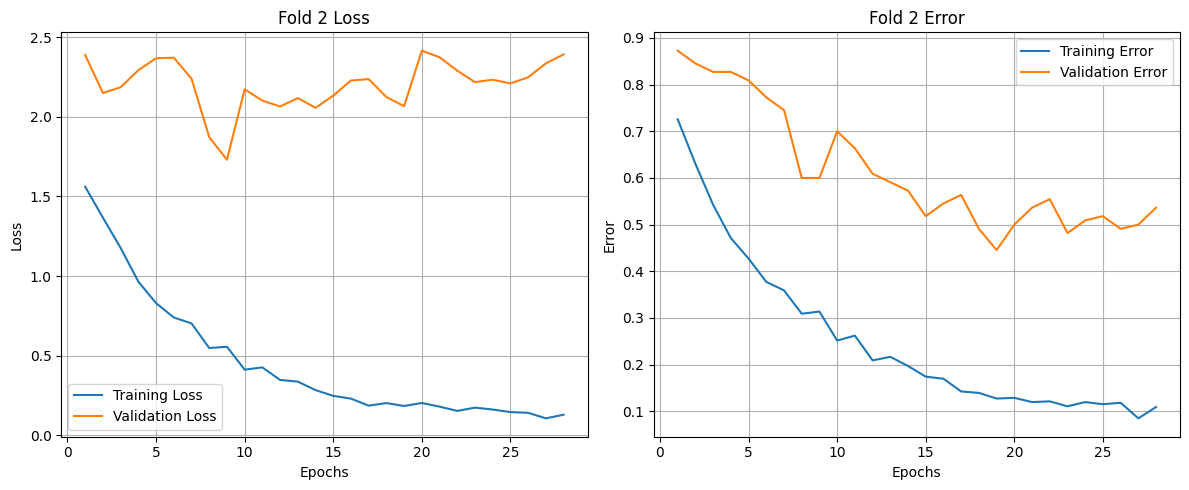


--- Fold 3/7 ---
Epoch 1: Miglior modello salvato (Train Loss=1.5351)
Epoch 1/50 | Train Loss: 1.5351 | Train Acc: 0.2697 | Train Recall: 0.2697 | Val Loss: 2.4405 | Val Acc: 0.1818 | Val Recall: 0.2789
Epoch 2: Miglior modello salvato (Train Loss=1.2974)
Epoch 2/50 | Train Loss: 1.2974 | Train Acc: 0.3909 | Train Recall: 0.3829 | Val Loss: 2.2591 | Val Acc: 0.1727 | Val Recall: 0.2724
Epoch 3: Miglior modello salvato (Train Loss=1.1547)
Epoch 3/50 | Train Loss: 1.1547 | Train Acc: 0.4439 | Train Recall: 0.4440 | Val Loss: 2.0656 | Val Acc: 0.2636 | Val Recall: 0.4218
Epoch 4: Miglior modello salvato (Train Loss=1.0061)
Epoch 4/50 | Train Loss: 1.0061 | Train Acc: 0.5485 | Train Recall: 0.5438 | Val Loss: 1.8410 | Val Acc: 0.2909 | Val Recall: 0.4700
Epoch 5: Miglior modello salvato (Train Loss=0.9420)
Epoch 5/50 | Train Loss: 0.9420 | Train Acc: 0.5485 | Train Recall: 0.5465 | Val Loss: 2.0859 | Val Acc: 0.2455 | Val Recall: 0.3866
Epoch 6: Miglior modello salvato (Train Loss=0.7122)

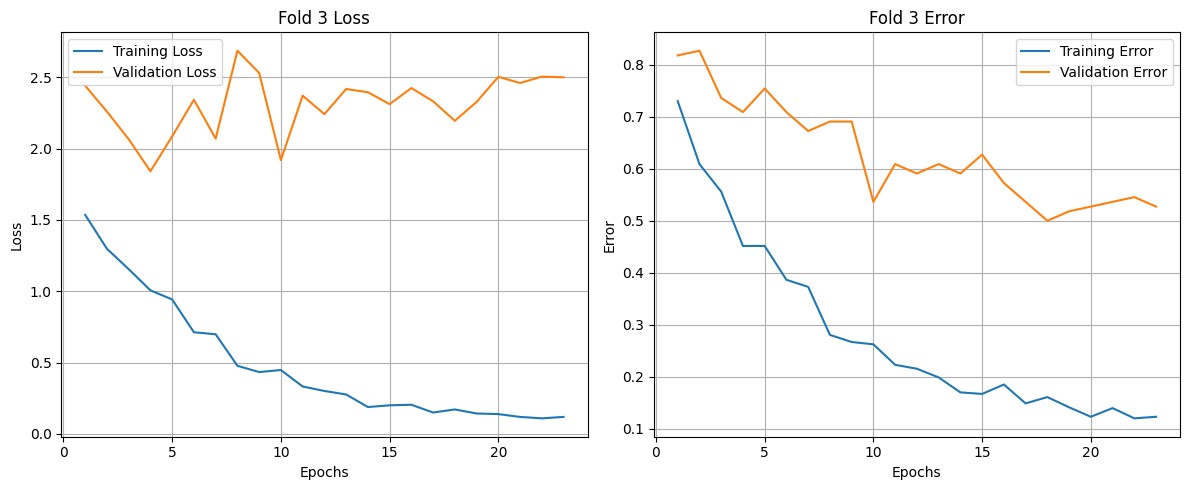


--- Fold 4/7 ---
Epoch 1: Miglior modello salvato (Train Loss=1.6038)
Epoch 1/50 | Train Loss: 1.6038 | Train Acc: 0.2273 | Train Recall: 0.2340 | Val Loss: 2.2473 | Val Acc: 0.1364 | Val Recall: 0.2067
Epoch 2: Miglior modello salvato (Train Loss=1.3032)
Epoch 2/50 | Train Loss: 1.3032 | Train Acc: 0.3788 | Train Recall: 0.3648 | Val Loss: 2.3078 | Val Acc: 0.1455 | Val Recall: 0.3167
Epoch 3: Miglior modello salvato (Train Loss=1.1058)
Epoch 3/50 | Train Loss: 1.1058 | Train Acc: 0.4576 | Train Recall: 0.4589 | Val Loss: 2.0477 | Val Acc: 0.2636 | Val Recall: 0.4667
Epoch 4: Miglior modello salvato (Train Loss=0.8862)
Epoch 4/50 | Train Loss: 0.8862 | Train Acc: 0.5530 | Train Recall: 0.5313 | Val Loss: 2.4254 | Val Acc: 0.1818 | Val Recall: 0.3879
Epoch 5/50 | Train Loss: 0.9822 | Train Acc: 0.5288 | Train Recall: 0.5480 | Val Loss: 1.9301 | Val Acc: 0.3091 | Val Recall: 0.4364
Epoch 6: Miglior modello salvato (Train Loss=0.7705)
Epoch 6/50 | Train Loss: 0.7705 | Train Acc: 0.6136 

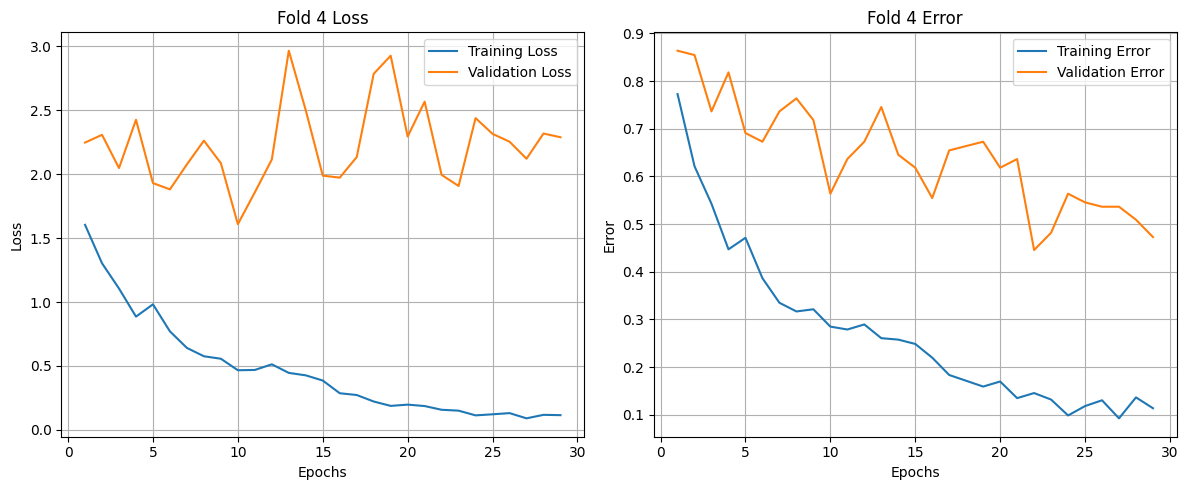


--- Fold 5/7 ---
Epoch 1: Miglior modello salvato (Train Loss=1.5108)
Epoch 1/50 | Train Loss: 1.5108 | Train Acc: 0.2742 | Train Recall: 0.2709 | Val Loss: 2.1472 | Val Acc: 0.1818 | Val Recall: 0.3216
Epoch 2: Miglior modello salvato (Train Loss=1.2909)
Epoch 2/50 | Train Loss: 1.2909 | Train Acc: 0.3758 | Train Recall: 0.3725 | Val Loss: 2.2218 | Val Acc: 0.2545 | Val Recall: 0.4415
Epoch 3: Miglior modello salvato (Train Loss=1.1955)
Epoch 3/50 | Train Loss: 1.1955 | Train Acc: 0.4076 | Train Recall: 0.4261 | Val Loss: 2.5704 | Val Acc: 0.2000 | Val Recall: 0.4187
Epoch 4: Miglior modello salvato (Train Loss=1.0703)
Epoch 4/50 | Train Loss: 1.0703 | Train Acc: 0.4833 | Train Recall: 0.4873 | Val Loss: 1.8998 | Val Acc: 0.2818 | Val Recall: 0.5495
Epoch 5: Miglior modello salvato (Train Loss=0.9069)
Epoch 5/50 | Train Loss: 0.9069 | Train Acc: 0.5273 | Train Recall: 0.5449 | Val Loss: 2.7021 | Val Acc: 0.2636 | Val Recall: 0.5059
Epoch 6: Miglior modello salvato (Train Loss=0.7967)

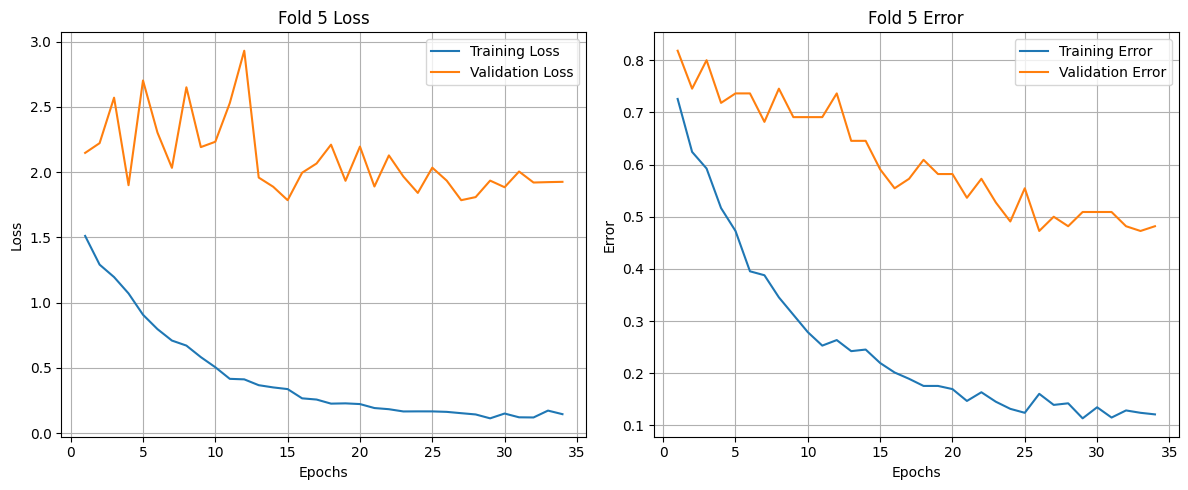


--- Fold 6/7 ---
Epoch 1: Miglior modello salvato (Train Loss=1.5553)
Epoch 1/50 | Train Loss: 1.5553 | Train Acc: 0.2576 | Train Recall: 0.2480 | Val Loss: 2.3714 | Val Acc: 0.1455 | Val Recall: 0.2940
Epoch 2: Miglior modello salvato (Train Loss=1.3643)
Epoch 2/50 | Train Loss: 1.3643 | Train Acc: 0.3273 | Train Recall: 0.3303 | Val Loss: 1.9215 | Val Acc: 0.2636 | Val Recall: 0.5040
Epoch 3: Miglior modello salvato (Train Loss=1.0080)
Epoch 3/50 | Train Loss: 1.0080 | Train Acc: 0.5106 | Train Recall: 0.5008 | Val Loss: 1.8272 | Val Acc: 0.3000 | Val Recall: 0.5275
Epoch 4: Miglior modello salvato (Train Loss=0.9590)
Epoch 4/50 | Train Loss: 0.9590 | Train Acc: 0.5424 | Train Recall: 0.5337 | Val Loss: 2.0340 | Val Acc: 0.2727 | Val Recall: 0.4440
Epoch 5: Miglior modello salvato (Train Loss=0.8162)
Epoch 5/50 | Train Loss: 0.8162 | Train Acc: 0.5909 | Train Recall: 0.5818 | Val Loss: 2.5157 | Val Acc: 0.2182 | Val Recall: 0.3913
Epoch 6: Miglior modello salvato (Train Loss=0.7963)

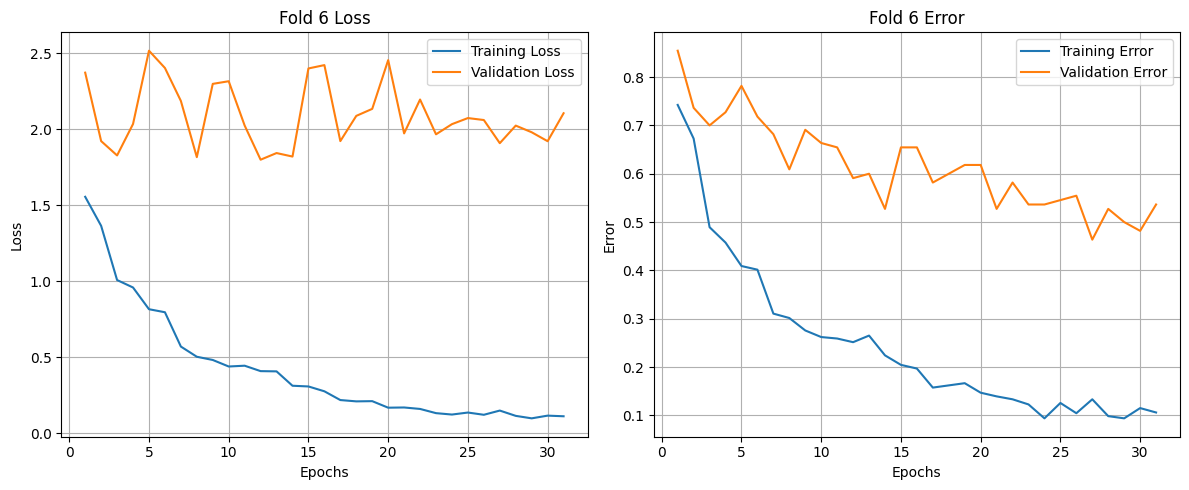


--- Fold 7/7 ---
Epoch 1: Miglior modello salvato (Train Loss=1.5381)
Epoch 1/50 | Train Loss: 1.5381 | Train Acc: 0.2788 | Train Recall: 0.2745 | Val Loss: 2.2035 | Val Acc: 0.1909 | Val Recall: 0.2778
Epoch 2: Miglior modello salvato (Train Loss=1.4106)
Epoch 2/50 | Train Loss: 1.4106 | Train Acc: 0.3318 | Train Recall: 0.3441 | Val Loss: 2.4975 | Val Acc: 0.1818 | Val Recall: 0.4122
Epoch 3: Miglior modello salvato (Train Loss=1.0734)
Epoch 3/50 | Train Loss: 1.0734 | Train Acc: 0.4818 | Train Recall: 0.4743 | Val Loss: 2.1905 | Val Acc: 0.2182 | Val Recall: 0.4008
Epoch 4: Miglior modello salvato (Train Loss=1.0683)
Epoch 4/50 | Train Loss: 1.0683 | Train Acc: 0.5045 | Train Recall: 0.5019 | Val Loss: 2.2397 | Val Acc: 0.1909 | Val Recall: 0.4600
Epoch 5: Miglior modello salvato (Train Loss=0.8312)
Epoch 5/50 | Train Loss: 0.8312 | Train Acc: 0.5652 | Train Recall: 0.5722 | Val Loss: 2.1331 | Val Acc: 0.3091 | Val Recall: 0.5295
Epoch 6: Miglior modello salvato (Train Loss=0.6467)

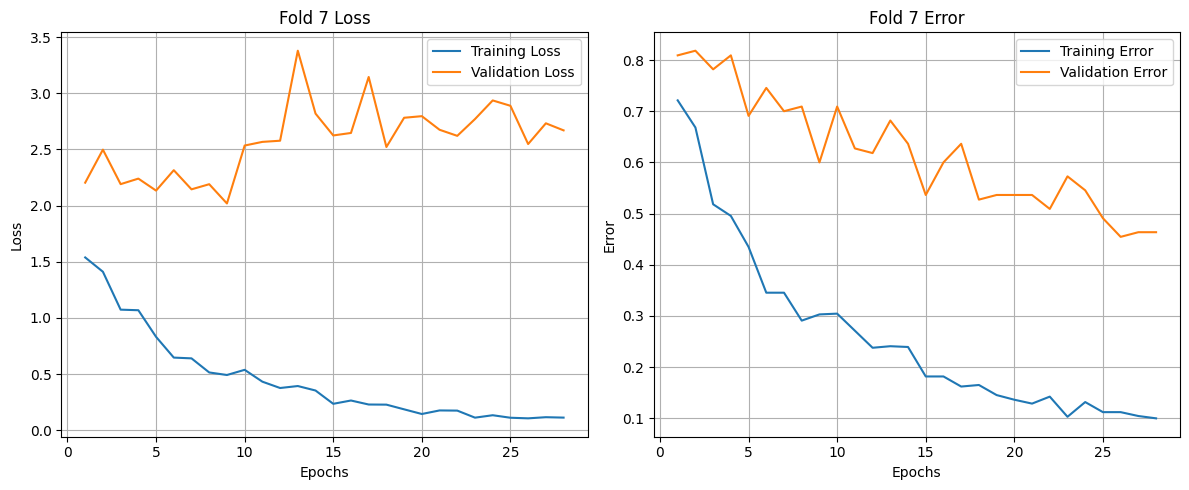


K-Fold Cross-Validation completed. Average Val Accuracy: 0.5091, Average Val Recall: 0.5966


In [21]:
# ========================
# Dataset
# ========================
class CryEmbeddingsDataset(Dataset):
    def __init__(self, embeddings_file):
        self.embeddings, self.labels = torch.load(embeddings_file)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

# ========================
# TransformerClassifier
# ========================
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=2048, embed_dim=256, num_heads=4, num_layers=2,
                 hidden_dim=512, num_classes=5, dropout=0.5):
        super(TransformerClassifier, self).__init__()
        self.input_proj = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        if x.ndim == 2:
            x = x.unsqueeze(1)  # sequenza di un passo se embedding statico
        x = self.input_proj(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.fc_out(x)



# ========================
# Parametri
# ========================
embedding_dim = 2048  # dimensione embedding PANNs
n_classes = 5  # aggiorna secondo le tue classi
k_folds = 7
batch_size = 16
n_epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset completo
full_dataset = CryEmbeddingsDataset("embeddings/train.pt")


# ========================
# K-Fold Cross Validation
# ========================
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lista per salvare risultati di tutti i fold
fold_results = []


# ========================
# Definizione EarlyStopping
# ========================
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.should_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0



# ========================
# Loop sui fold
# ========================
for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"\n--- Fold {fold+1}/{k_folds} ---")

    # Subset per train/validation
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    # Calcolo class weights sul train subset
    train_labels = np.array([full_dataset[i][1] for i in train_idx])
    class_counts = np.bincount(train_labels)
    class_weights = 1. / class_counts
    class_weights_tensor = torch.tensor(np.clip(class_weights, 0, 10), dtype=torch.float32).to(device)

    # WeightedRandomSampler
    sample_weights = [class_weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # DataLoader
    train_loader = DataLoader(train_subset, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # ========================
    # Istanzia il modello per il fold
    # ========================
    model = TransformerClassifier(input_dim=embedding_dim, num_classes=n_classes).to(device)

    # Loss e ottimizzatore
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

    # Early stopping
    early_stopping = EarlyStopping(patience=20)

    # Variabili per tracking
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_train_loss = float('inf')
    best_model_path = f"best_model_fold{fold+1}.pt"

    # ========================
    # Training loop
    # ========================
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0
        all_preds, all_labels = [], []

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

        # Metriche training
        avg_train_loss = running_loss / len(train_loader)
        acc_train = np.mean(np.array(all_preds) == np.array(all_labels))
        recall_train = recall_score(all_labels, all_preds, average='macro')

        # Salvataggio miglior modello basato su train loss
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Epoch {epoch+1}: Miglior modello salvato (Train Loss={best_train_loss:.4f})")

        # Validation
        model.eval()
        val_loss_total = 0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss_total += loss.item()
                _, preds = outputs.max(1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(y.cpu().numpy())

        val_loss_mean = val_loss_total / len(val_loader)
        val_acc = np.mean(np.array(val_preds) == np.array(val_labels))
        val_recall = recall_score(val_labels, val_preds, average='macro')

        # Scheduler + Early stopping
        scheduler.step(val_loss_mean)
        early_stopping(val_loss_mean)
        if early_stopping.should_stop:
            print("Early stopping triggered.")
            break

        # Tracking metriche
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss_mean)
        train_accuracies.append(acc_train)
        val_accuracies.append(val_acc)

        # Stampa per epoch
        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {acc_train:.4f} | Train Recall: {recall_train:.4f} | "
              f"Val Loss: {val_loss_mean:.4f} | Val Acc: {val_acc:.4f} | Val Recall: {val_recall:.4f}")

    # Salva metriche fold
    fold_results.append({
        "fold": fold+1,
        "best_train_loss": best_train_loss,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "val_recall": val_recall
    })

    # ========================
    # Grafici per fold
    # ========================
    epochs_range = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold+1} Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(epochs_range, [1-x for x in train_accuracies], label='Training Error')
    plt.plot(epochs_range, [1-x for x in val_accuracies], label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title(f'Fold {fold+1} Error')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ========================
# Risultati finali K-Fold
# ========================
avg_val_acc = np.mean([r['val_accuracies'][-1] for r in fold_results])
avg_val_recall = np.mean([r['val_recall'] for r in fold_results])
print(f"\nK-Fold Cross-Validation completed. Average Val Accuracy: {avg_val_acc:.4f}, Average Val Recall: {avg_val_recall:.4f}")


## 📉 RISULTATI OTTENUTI

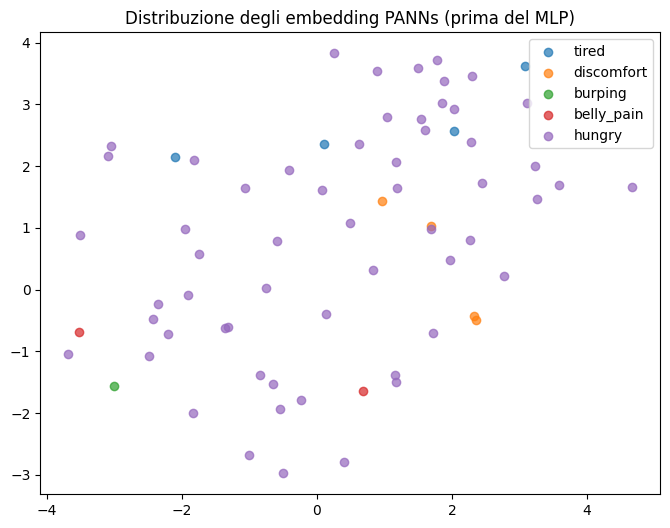

In [25]:
test_dataset  = CryEmbeddingsDataset("embeddings/test.pt")
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()

embeddings = []
labels_all = []

with torch.no_grad():
    for emb, label in test_loader:  # emb già è embedding PANNs
        embeddings.append(emb.cpu().numpy())
        labels_all.extend(label.numpy())

embeddings = np.concatenate(embeddings, axis=0)

# Riduzione dimensionale (es: t-SNE)
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

# Visualizza
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(label2idx.keys()):
    plt.scatter(
        emb_2d[np.array(labels_all) == i, 0],
        emb_2d[np.array(labels_all) == i, 1],
        label=class_name, alpha=0.7
    )
plt.legend()
plt.title("Distribuzione degli embedding PANNs (prima del MLP)")
plt.show()



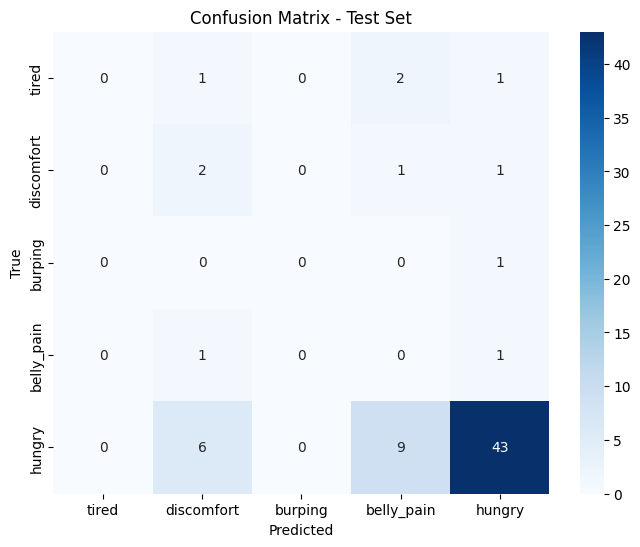


 Classification Report:
              precision    recall  f1-score   support

       tired       0.00      0.00      0.00         4
  discomfort       0.20      0.50      0.29         4
     burping       0.00      0.00      0.00         1
  belly_pain       0.00      0.00      0.00         2
      hungry       0.91      0.74      0.82        58

    accuracy                           0.65        69
   macro avg       0.22      0.25      0.22        69
weighted avg       0.78      0.65      0.71        69



In [26]:
#=====================================================
# Matrice di confusione - classificazione multiclasse
#=====================================================
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for spec, label in test_loader:
        spec, label = spec.to(device), label.to(device)
        outputs = model(spec)
        _, predicted = outputs.max(1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(label.cpu().numpy())

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label2idx.keys()),
            yticklabels=list(label2idx.keys()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Report completo (precision, recall, f1)
print("\n Classification Report:")
print(classification_report(test_labels, test_preds, target_names=list(label2idx.keys())))




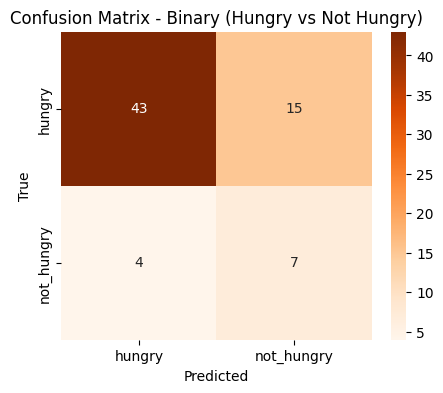


=== Classification Report (BINARY: hungry vs not_hungry) ===
              precision    recall  f1-score   support

      hungry       0.91      0.74      0.82        58
  not_hungry       0.32      0.64      0.42        11

    accuracy                           0.72        69
   macro avg       0.62      0.69      0.62        69
weighted avg       0.82      0.72      0.76        69



In [27]:
# =================================================
# CMatrice di confusione - classificazione binaria
# =================================================
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for spec, label in test_loader:
        spec, label = spec.to(device), label.to(device)
        outputs = model(spec)
        _, predicted = outputs.max(1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(label.cpu().numpy())

# Mappa indici -> label
idx2label = {v: k for k, v in label2idx.items()}

# Funzione di collasso: hungry (0), not_hungry (1)
def collapse_to_binary(y):
    return [0 if idx2label[i].lower() == "hungry" else 1 for i in y]

# Conversione
binary_true  = collapse_to_binary(test_labels)
binary_preds = collapse_to_binary(test_preds)

# Matrice di confusione binaria
cm_bin = confusion_matrix(binary_true, binary_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm_bin, annot=True, fmt="d", cmap="Oranges",
            xticklabels=["hungry", "not_hungry"],
            yticklabels=["hungry", "not_hungry"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Binary (Hungry vs Not Hungry)")
plt.show()

# Report binario (precision, recall, F1)
print("\n=== Classification Report (BINARY: hungry vs not_hungry) ===")
print(classification_report(binary_true, binary_preds, target_names=["hungry", "not_hungry"]))
